# Pre-Trained LLMs for Text Summarization and Extractive Question Answering
Elizabeth Van Der Schaaf

November 17, 2024
## Introduction
Large Language Models (LLMs) leverage deep learning and transformer architectures to handle massive datasets. They utilize millions or billions of parameters, enabling them to perform a wide variety of nuanced tasks. Some of their capabilites include text generation, translation, and summarization.

This report will examine a couple of these cabablities using pre-trained models from the Hugging Face library. First two models will be compared for their text summarization capabilities. Afterwards an extractive question answering model will be explored. 

## Analysis 

#### Text Summarization
We'll load a Bart model and a Bert model from the transformers package.

In [33]:
import warnings
warnings.filterwarnings('ignore')


from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# Load Bart tokenizer and model
tokenizer_bart = AutoTokenizer.from_pretrained("facebook/bart-large-cnn")
model_bart = AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-large-cnn")

# Load Bert tokenizer and model
tokenizer_bert = AutoTokenizer.from_pretrained("patrickvonplaten/bert2bert_cnn_daily_mail")
model_bert = AutoModelForSeq2SeqLM.from_pretrained("patrickvonplaten/bert2bert_cnn_daily_mail")

Config of the encoder: <class 'transformers.models.bert.modeling_bert.BertModel'> is overwritten by shared encoder config: BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "return_dict": false,
  "transformers_version": "4.46.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

Config of the decoder: <class 'transformers.models.bert.modeling_bert.BertLMHeadModel'> is overwritten by shared decoder config: BertConfig {
  "_name_or_path": "bert-base-uncased",
  "add_cross_attention"

The data will be from a popular dataset of news articles taken from CNN and the Daily Mail (_CNN-DailyMail News Text Summarization,_ 2021).

In [34]:
import pandas as pd

cnn = pd.read_csv("cnn_test.csv")
print(cnn.head())

                                         id  \
0  92c514c913c0bdfe25341af9fd72b29db544099b   
1  2003841c7dc0e7c5b1a248f9cd536d727f27a45a   
2  91b7d2311527f5c2b63a65ca98d21d9c92485149   
3  caabf9cbdf96eb1410295a673e953d304391bfbb   
4  3da746a7d9afcaa659088c8366ef6347fe6b53ea   

                                             article  \
0  Ever noticed how plane seats appear to be gett...   
1  A drunk teenage boy had to be rescued by secur...   
2  Dougie Freedman is on the verge of agreeing a ...   
3  Liverpool target Neto is also wanted by PSG an...   
4  Bruce Jenner will break his silence in a two-h...   

                                          highlights  
0  Experts question if  packed out planes are put...  
1  Drunk teenage boy climbed into lion enclosure ...  
2  Nottingham Forest are close to extending Dougi...  
3  Fiorentina goalkeeper Neto has been linked wit...  
4  Tell-all interview with the reality TV star, 6...  


In [35]:
# function to summarize text
def summarize(tokenizer, model, text, max_length=1000, min_length=40):
    # Encode the input text
    inputs = tokenizer.encode( text, return_tensors='pt', max_length=1024, truncation=True)
    # Generate summary using the model
    summary_ids = model.generate(inputs, max_length=max_length, min_length=min_length, length_penalty=2.0, num_beams=4, early_stopping=True)
    # Decode the summary
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

In [36]:
for num in range(3):
    article = cnn['article'].iloc[num]
    print(f"Highlights (reference summary):\n {cnn['highlights'].iloc[num]}\n")

    method = "BART"
    summary_bart = summarize(tokenizer_bart, model_bart, article)
    print(f"Summary by {method} model\n original length = {len(article)}, summary length = {len(summary_bart)} chars: \n\n\t {summary_bart}\n")

    method = "BERT"
    summary_bert = summarize(tokenizer_bert, model_bert, article)
    print(f"Summary by {method} model\n original length = {len(article)}, summary length = {len(summary_bert)} chars: \n\n\t {summary_bert}\n")
    print("-"*40) 

Highlights (reference summary):
 Experts question if  packed out planes are putting passengers at risk .
U.S consumer advisory group says minimum space must be stipulated .
Safety tests conducted on planes with more leg room than airlines offer .

Summary by BART model
 original length = 2126, summary length = 321 chars: 

	 U.S consumer advisory group set up by Department of Transportation said that while the government is happy to set standards for animals flying on planes, it doesn't stipulate a minimum amount of space for humans. Tests conducted by the FAA use planes with a 31 inch pitch, a standard which on some airlines has decreased.

Summary by BERT model
 original length = 2126, summary length = 244 chars: 

	 the government is happy to set standards for animals flying on planes. but the government doesn't stipulate a minimum amount of space for humans. many economy seats on united airlines have 30 inches of room, while some airlines offer 28 inches.

-------------------------

One way to evaluate LLM generated summaries is the ROUGE metric (Recal-Oriented Understudy for Gisting Evaluation). This involves comparison of model-generated output against a pre-generated reference summary. There are several flavors of ROUGE evaluation. ROUGE-N looks at the overlap of N-grams between the model's output and the reference, giving an indication of precision and recall. ROUGE-L looks at the maximum sequence of words (Longest Common Subsequence - LCS) in the two summaries. ROUGE-S looks at skip-bigrams, providing a wider view of similarity (Waheed, 2023). ROUGE-Lsum is similar to ROUGE-L, but considers the entirety of the summary.

We will consider ROUGE-1 and ROUGE-2 (single and bi-gram overlap) as well as ROUGE-L and ROUGE-Lsum.

In [37]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer
import evaluate
from datasets import Dataset
import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
# Load ROUGE metric
rouge = evaluate.load("rouge")

# Convert DataFrame to Hugging Face Dataset
test_data = Dataset.from_pandas(cnn)

# Select a subset of the dataset for evaluation
test_data = test_data.select(range(20))

# Set batch size
batch_size = 20 

# Function to generate summaries
def generate_summary(batch, model, tokenizer):
    # Tokenizer will automatically set [BOS] <text> [EOS] for the respective models
    inputs = tokenizer(batch["article"], padding="max_length", truncation=True, max_length=512, return_tensors="pt")
    input_ids = inputs.input_ids
    attention_mask = inputs.attention_mask

    # Generate summary using the model
    outputs = model.generate(input_ids, attention_mask=attention_mask)

    # Decode the generated output and remove special tokens
    output_str = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    batch["pred"] = output_str
    return batch

# Loop through models and their tokenizers
models = [model_bert, model_bart]  # List of models
tokenizers = [tokenizer_bert, tokenizer_bart]  # Corresponding tokenizers
model_names = ["BERT", "BART"]  # Names for the models for printing

# Dictionary to store ROUGE scores for each model
rouge_scores = { "model_name": [], "rouge1": [], "rouge2": [], "rougeL": [], "rougeLsum": [] }

# Iterate through both models and compute ROUGE scores for each
for model, tokenizer, model_name in zip(models, tokenizers, model_names):
    print(f"Evaluating with {model_name} model.")

    # Apply the summarization function to the dataset
    results = test_data.map(generate_summary, batched=True, batch_size=batch_size, remove_columns=["article"], fn_kwargs={"model": model, "tokenizer": tokenizer})

    # Get predictions and reference summaries
    pred_str = results["pred"]
    label_str = results["highlights"]

    # Compute ROUGE scores
    rouge1_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge1"])["rouge1"]
    rouge2_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge2"])["rouge2"]
    rougeL_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rougeL"])["rougeL"]
    rougeLsum_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rougeLsum"])["rougeLsum"]

    # Add results to the dictionary
    rouge_scores["model_name"].append(model_name)
    rouge_scores["rouge1"].append(rouge1_output)
    rouge_scores["rouge2"].append(rouge2_output)
    rouge_scores["rougeL"].append(rougeL_output)
    rouge_scores["rougeLsum"].append(rougeLsum_output)

    # Print ROUGE scores for the current model
    print(f"ROUGE-1 Score for {model_name}: {rouge1_output}")
    print(f"ROUGE-2 Score for {model_name}: {rouge2_output}")
    print(f"ROUGE-L Score for {model_name}: {rougeL_output}")
    print(f"ROUGE-Lsum Score for {model_name}: {rougeLsum_output}")
    print("\n")

# (Google Colab, n.d.)

Evaluating with BERT model.


Map:   0%|          | 0/20 [00:00<?, ? examples/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


ROUGE-1 Score for BERT: 0.3981656652500931
ROUGE-2 Score for BERT: 0.1699910493720534
ROUGE-L Score for BERT: 0.2631048040960148
ROUGE-Lsum Score for BERT: 0.3407507827238032


Evaluating with BART model.


Map:   0%|          | 0/20 [00:00<?, ? examples/s]

ROUGE-1 Score for BART: 0.44009083889046535
ROUGE-2 Score for BART: 0.22160035942296707
ROUGE-L Score for BART: 0.3156369142487833
ROUGE-Lsum Score for BART: 0.38467592455876054




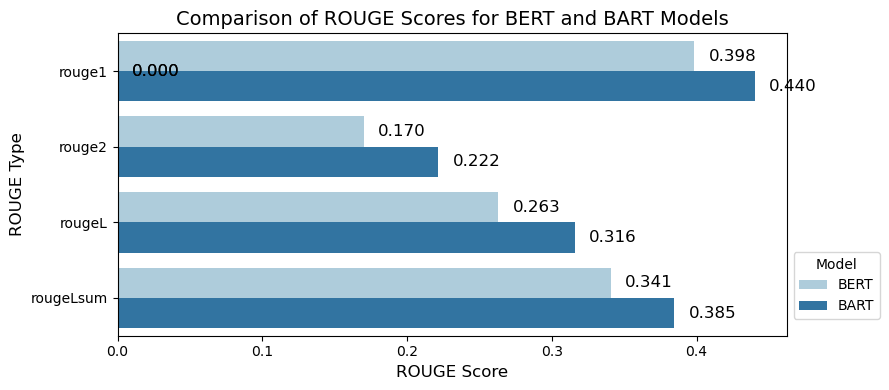

__Figure 1.__ ROUGE scores for Bert and Bart models.

In [39]:
from IPython.display import Markdown, display as i_display

# Convert the results dictionary into a pandas DataFrame
df_scores = pd.DataFrame(rouge_scores)

# Reshape the dataframe for plotting
df_scores_melted = df_scores.melt(id_vars=["model_name"], var_name="ROUGE Score", value_name="Score")

# Plot the bar chart using seaborn
plt.figure(figsize=(9, 4))
ax = sns.barplot(data=df_scores_melted, x="Score", y="ROUGE Score", hue="model_name", orient="h", palette="Paired")

# Add chart labels
plt.title("Comparison of ROUGE Scores for BERT and BART Models", fontsize=14)
plt.xlabel("ROUGE Score", fontsize=12)
plt.ylabel("ROUGE Type", fontsize=12)
# Move legend outside of the plot (to the right)
plt.legend(title="Model", loc="upper left", bbox_to_anchor=(1, .3))

# Add the score values at the ends of the bars
for p in ax.patches:
    # p.get_width() gives the length of the bar
    ax.text(p.get_width() + 0.01, p.get_y() + p.get_height() / 2, f'{p.get_width():.3f}', 
            horizontalalignment='left', verticalalignment='center', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()
i_display(Markdown("__Figure 1.__ ROUGE scores for Bert and Bart models."))

The Bart model outperformed Bert on all metrics. Its summaries are more similar to the reference summaries.

#### Extractive Question Answering
One task an LLM can be trained to do is extractive question answering. For this task the model is provided context and then asked to answer a question based on the context. One example of a model which has been trained in this manor is Hugging Face's roberta-base-squad2 model (_Deepset/Roberta-base-squad2 · Hugging Face,_ 2001). This model will now be investigated.

In [1]:
import numpy as np
import os
from prettytable import PrettyTable

os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"
from transformers import RobertaForQuestionAnswering, RobertaTokenizer

# Load pre-trained model and tokenizer
model_name = "deepset/roberta-base-squad2"
model = RobertaForQuestionAnswering.from_pretrained(model_name)
tokenizer = RobertaTokenizer.from_pretrained(model_name)

The model was trained on the SQuAD (Stanford Question Answering Dataset), which includes 'unanswerable questions.' These are questions for which the given context does not provide an answer. Let's use this to get an idea of model performance.

In [2]:
from datasets import load_dataset

# Load SQuAD dataset (v2 includes unanswerable questions)
dataset = load_dataset("squad_v2")

# Use validation split for evaluation
val_data = dataset['validation']

In [3]:
from transformers import pipeline

# Set up the QA pipeline
qa_pipeline = pipeline("question-answering", model=model, tokenizer=tokenizer)

# Set confidence threshold
CONFIDENCE = 0.4

Confidence threshold has been set to 0.4. Anything below this threshold is not a confident answer and will be considered a 'No answer.' Let's look at some of the data and answers provided by the model.

In [4]:
# Loop through the first 10 examples in val_data
subset = val_data.select(range(10))

for idx, example in enumerate(subset):
    context = example['context']
    question = example['question']

    # Use the pipeline to get the answer
    result = qa_pipeline(question=question, context=context)

    if result['score'] > CONFIDENCE:
        ans = result['answer']
    else:
        ans = 'No answer.'

    # Output the question, answer, and confidence score
    print(f"Example {idx + 1}:")
    print(f"Question: {question}")
    print(f"Answer: {ans}")
    print(f"Confidence: {result['score']:.4f}")
    print("-" * 50)

Example 1:
Question: In what country is Normandy located?
Answer: France.
Confidence: 0.9817
--------------------------------------------------
Example 2:
Question: When were the Normans in Normandy?
Answer: 10th and 11th centuries
Confidence: 0.6162
--------------------------------------------------
Example 3:
Question: From which countries did the Norse originate?
Answer: Denmark, Iceland and Norway
Confidence: 0.4825
--------------------------------------------------
Example 4:
Question: Who was the Norse leader?
Answer: No answer.
Confidence: 0.2665
--------------------------------------------------
Example 5:
Question: What century did the Normans first gain their separate identity?
Answer: 10th
Confidence: 0.6701
--------------------------------------------------
Example 6:
Question: Who gave their name to Normandy in the 1000's and 1100's
Answer: No answer.
Confidence: 0.0002
--------------------------------------------------
Example 7:
Question: What is France a region of?
Answ

Looking at the confidence scores of these answers gives an idea of their likelihood of being correct. The model lacks confidence when not given enough context to answer the question.

In [5]:
# Function to evaluate model
def evaluate_model(dataset, pipeline, confidence_threshold):
    predictions = []
    references = []
    
    for example in dataset:
        result = pipeline(question=example['question'], context=example['context'])
        
        if result['score'] <= confidence_threshold:
            predicted_answer = ""
        else:
            predicted_answer = result['answer']
        
        predictions.append(predicted_answer)
        
        if len(example['answers']['text']) > 0:
            references.append(example['answers']['text'][0])
        else:
            references.append("")
    
    return predictions, references

# Evaluate on a subset of the dataset
eval_dataset = val_data.select(range(100))
predictions, references = evaluate_model(eval_dataset, qa_pipeline, CONFIDENCE)

Now that we have some answers (predictions) we can compare them to the reference answers. We'll look for exact matches but also cases where there is some overlap between the prediction and the reference answer (a modified F1 score).

In [41]:
import re

# Normalize function to process answers (this normalizes text to lowercase and removes punctuation)
def normalize_answer(answer):
    if not answer:
        return ""
    answer = answer.lower()
    answer = re.sub(r"\s+", " ", answer)
    answer = re.sub(r"[^\w\s]", "", answer)
    return answer.strip()

# F1 score calculation function using token-level comparison (precision and recall)
def f1_score(pred, ref):
    pred_tokens = set(pred.split())  # Tokenize prediction into a set of words
    ref_tokens = set(ref.split())    # Tokenize reference into a set of words
    
    common_tokens = pred_tokens.intersection(ref_tokens)  # Find common tokens between pred and ref
    if len(pred_tokens) + len(ref_tokens) == 0:
        return 1.0  # If both are empty (no answer), return perfect F1 score (1)
    
    # Precision: how many common tokens are in the prediction
    precision = len(common_tokens) / len(pred_tokens) if pred_tokens else 0
    
    # Recall: how many common tokens are in the reference
    recall = len(common_tokens) / len(ref_tokens) if ref_tokens else 0
    
    # F1 score
    if precision + recall == 0:
        return 0.0
    return 2 * (precision * recall) / (precision + recall)

# Function to calculate Exact Match (EM) and modified F1 score
def compute_em_and_f1(prediction, ground_truth):
    # Normalize both the predicted and the ground truth answers
    prediction = normalize_answer(prediction)
    ground_truth = normalize_answer(ground_truth)

    # Exact Match (EM)
    em = int(prediction == ground_truth)

    # If both prediction and ground truth are 'no answer' (empty string), return EM=1 and F1=0
    if prediction == "" and ground_truth == "":
        return em, 0.0

    # F1 score is computed using the provided F1 score function (token-level)
    f1 = f1_score(prediction, ground_truth)
    
    return em, f1

# Function to evaluate EM and modified F1 score on a dataset
def evaluate_em_f1(predictions, references, confidence_threshold):
    total_em = 0
    total_f1 = 0
    total_questions = len(predictions)
    
    # Loop through each prediction and reference
    for pred, ref in zip(predictions, references):
        # If the model predicted 'no answer'
        if pred == "":
            if ref == "":  # True Negative: both model and ground truth have 'no answer'
                total_em += 1  # True Negative counts as correct for EM (no mistake)
                total_f1 += 0  # No answer, so F1 does not change
            else:  # False Negative: model says no answer but ground truth has an answer
                total_em += 0  # No Exact Match for False Negative
                total_f1 += 0  # No F1 for False Negative
        else:
            # If the model provided an answer, we calculate EM and F1 normally
            em, f1 = compute_em_and_f1(pred, ref)
            total_em += em
            total_f1 += f1
    
    # Calculate average EM and F1
    average_em = total_em / total_questions
    average_f1 = total_f1 / total_questions

    return average_em, average_f1
# (OpenAI)

In [42]:
# Get EM and F1 scores
average_em, average_f1 = evaluate_em_f1(predictions, references, CONFIDENCE)

print(f"Average Exact Match (EM) Score: {average_em:.4f}")
print(f"Average modified F1 Score: {average_f1:.4f}")

Average Exact Match (EM) Score: 0.7100
Average modified F1 Score: 0.2807


Exact matches look good. The modified F1 score is a little low.

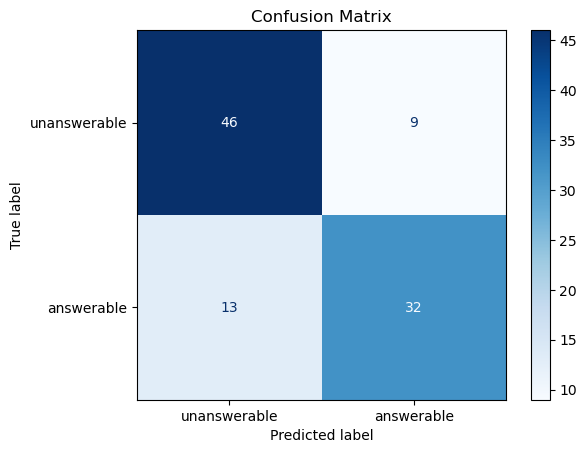

__Figure 2.__ Confusion matrix for Roberta QA model on subset of SQuAD data.

In [43]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support

# Calculate confusion matrix for unanswerable vs answerable questions
# We assume the prediction is "" for unanswerable questions and any non-"" answer for answerable ones.
y_true = [1 if ref != "" else 0 for ref in references]  # 1 if answerable, 0 if unanswerable
y_pred = [1 if pred != "" else 0 for pred in predictions]  # 1 if predicted answer, 0 if predicted no answer

cmatrix = confusion_matrix(y_true, y_pred)
target_names = ['unanswerable', 'answerable']
display = ConfusionMatrixDisplay(confusion_matrix = cmatrix, display_labels = target_names)
display.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
i_display(Markdown("__Figure 2.__ Confusion matrix for Roberta QA model on subset of SQuAD data."))

In [44]:
# Calculate Precision, Recall, F1 for answerable vs. unanswerable questions
precision, recall, fscore, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')

table1 = PrettyTable()

# Add columns
table1.field_names = ["Metric", "Value"]

# Add rows
table1.add_row(["Precision", f"{precision:.4f}"])
table1.add_row(["Recall", f"{recall:.4f}"])
table1.add_row(["F1-Score", f"{fscore:.4f}"])
table1.align["Metric"] = "l"
print(table1)
i_display(Markdown("__Table 1.__ Evaluation metrics for Roberta QA model on subset of SQuAD data."))

+-----------+--------+
| Metric    | Value  |
+-----------+--------+
| Precision | 0.7805 |
| Recall    | 0.7111 |
| F1-Score  | 0.7442 |
+-----------+--------+


__Table 1.__ Evaluation metrics for Roberta QA model on subset of SQuAD data.

For fun, we can test the model on some new material.

In [45]:
# Context is taken from my symbolic logic textbook
context = '''Logic may be defined as the organized body of knowledge, or science, that evaluates arguments.
All of us encounter arguments in our day-to-day experience. We read them in books and newspapers, hear them
on television, and formulate them when communicating with friends and associates. The aim of logic is to
develop a system of methods and principles that we may use as criteria for evaluating the arguments of others
and as guides in constructing arguments of our own. Among the benefits to be expected from the study of logic
is an increase in confidence that we are making sense when we criticize the arguments of others and when we 
advance arguments of our own.
An argument, in its simplest form, is a group of statements, one or more of which (the premises) are claimed
to provide support for, or reasons to believe, one of the others (the conclusion). Every argument may be placed
in either of two basic groups: those in which the premises really do support the conclusion and those in which 
they do not, even though they are claimed to. The former are said to be good arguments (at least to that extent),
the latter bad arguments. The purpose of logic, as the science that evaluates arguments, is thus to develop methods
and techniques that allow us to distinguish good arguments from bad.'''

In [46]:
question = "What is the study of logic?"

result = qa_pipeline(question=question, context=context)
print(result)

{'score': 0.028357205912470818, 'start': 1169, 'end': 1202, 'answer': 'science that evaluates arguments,'}


In [47]:
question = "What are the benefits of studying logic?"

result = qa_pipeline(question=question, context=context)
print(result)

{'score': 0.1417609304189682, 'start': 534, 'end': 581, 'answer': 'increase in confidence that we are making sense'}


In [48]:
question = "What is the purpose of logic?"

result = qa_pipeline(question=question, context=context)
print(result)

{'score': 0.14823214709758759, 'start': 1211, 'end': 1297, 'answer': 'to develop methods and techniques that allow us to distinguish good arguments from bad.'}


In [49]:
question = "Who is Benjamin Franklin?"

result = qa_pipeline(question=question, context=context)
print(result)

{'score': 1.3980442359340373e-09, 'start': 28, 'end': 94, 'answer': 'organized body of knowledge, or science, that evaluates arguments.'}


## Conclusion
It's wonderful how many pre-trained LLMs are readily available. Though these models may not be quite ready for a specific problem, they are a good starting off point. I did notice that these models do take time to run, which was expected.

I thought the Roberta-based question and answer model did better at answering questions about logic than I expected. It would be fun to play with it some more.

## References
_CNN-DailyMail News Text summarization._ (2021, October 23). Kaggle. [https://www.kaggle.com/datasets/gowrishankarp/newspaper-text-summarization-cnn-dailymail]

_deepset/roberta-base-squad2 · Hugging Face._ (2001, March 4). [https://huggingface.co/deepset/roberta-base-squad2]

Google Colab. (n.d.). [https://colab.research.google.com/drive/1Ekd5pUeCX7VOrMx94_czTkwNtLN32Uyu?usp=sharing#scrollTo=oOoSrwWarJAC]

OpenAI. (2024). _ChatGPT_ (Sept 2024) [AI model]. In respose to prompt, "Please provide an example for calculating exact match and F1 score." on 2024/11/17 [https://www.openai.com/chatgpt]

Waheed, A. (2023, June 17). _How to calculate ROUGE score in Python - the Python Code._ 
[https://thepythoncode.com/article/calculate-rouge-score-in-python]